In [18]:
import qiskit
import qiskit.providers.basic_provider as basic_provider
import qiskit.quantum_info as quantum_info
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
from qiskit_aer.primitives import Sampler

import random, itertools
import math
import matplotlib.pyplot as plt

qiskit.version.get_version_info()

'2.1.1'

# Algoritmo de Shor

O algoritmo de Shor possui 3 partes:
1. Reduzir o problema de fatoração ao problema de encontrar o período.
2. Encontrar o período usando computação quântica.
3. Calcular fatores usando o período calculado. 

In [19]:
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/hOlOY7NyMfs?start=75&end=126",560,315)

# Gerando N = p*q

### Algoritmo de Eratosthenes

In [20]:
def sieve( ): # gera primos usando o algoritmo de Eratosthenes
    D = {  }
    yield 2
    for q in itertools.islice(itertools.count(3), 0, None, 2):
        p = D.pop(q, None)
        if p is None:
            D[q*q] = q
            yield q
        else:
            x = p + q
            while x in D or not (x&1):
                x += p
            D[x] = p

def get_primes_sieve(n):
    return list(itertools.takewhile(lambda p: p<n, sieve())) # gera um primo para cada p em range(n)

def get_semiprime(n):
    primes = get_primes_sieve(n) # gera n inteiros primos
    l = len(primes)
    p = primes[random.randrange(l)] # seleciona um primo aleatoriamente
    q = primes[random.randrange(l)] # seleciona um primo aleatoriamente
    return p*q

In [21]:
N = get_semiprime(500)
N

36437

# Redução de fatoração para cálculo de período
A teoria dos números que fundamenta o algoritmo é a sequência modulo periódica. Por exemplo, tendo a sequência das potências de 2:

$1, 2, 4, 8, 16, 32, 64, 128, ...$

Quando calculamos o $mod15$ de cada elemento da sequência, obtemos a seguinte sequência periódica cujo período é 4:

$1, 2, 4, 8, 1, 2, 4, 8, ...$

Pode-se reduzir a fatoração de um número N para o cálculo do período da sequência $F(a) = x^a mod N$, onde x é coprimo de N, desde que a sequência seja periódica e $a>=0$.

Obs: como $x^0modN=1$, temos que $x^rmodN=1$, onde r é o período da sequência.

Podemos fazer uma manipulação algébrica para obter a fatoração de N:

$x^r=1 mod N$

$x^r=(x^{r/2})^2=1 mod N$

$(x^{r/2})^2 - 1=0 mod N \Rightarrow (x^{r/2}-1) (x^{r/2}+1)=0 mod N$

Portanto, como $(x^{r/2}-1) (x^{r/2}+1)$ é múltiplo de $N$, a fatoração de $N$ será $gdc(x^{r/2}-1,N)$ e $gdc(x^{r/2}+1,N)$, desde que $(x^{r/2}-1)$ e $(x^{r/2}+1)$ não sejam multiplos de N.

Exemplo: $N = 15$ e valores $1 < x < 15$

<img src='./images/Captura de tela 2025-07-29 114312.png'>

# Encontrando o período com computação quântica

1. Escolha um $T = 2^t$ tal que $N^2 <= T <= 2N^2$
2. Inicializar dois registradores de qubits com estado inicial 0:
    1. Registrador de argumento com $t$ qubits
    2. Registrador de função com $n = log{_2}{N}$ qubits
3. Aplicar portão de Hadamar em cada qubit do registrador 1 para gerar uma superposição igualitária entre todos os inteiros de $0$ a $T$.
4. Implementar a função de exponenciação modular $x^a mod N$ no registrador 2
    * $x$ será um coprimo de $N$.
    * O registrador 2 possui paralelismo quântico, portanto, a cada iteração, todos os valores de $0$ a $T$ são atrelados aos valores correspondentes de $x^a mod N$, acelerando a execução significativamente. 
5. Realizar uma transformação quântica de Fourier sobre o registrador 1, onde apenas os termos cujo valor corresponde a $z = qT/r$ ganham amplitude significativa.
    * Isso significa que a probabilidade desses termos aumenta significantemente em relação aos outros.
    * $q$ é um inteiro aleatório entre $0$ e $r-1$.
    * $r$ é o período de $x^a mod N$, que é o que se deseja encontrar.
6. Medir o registrador 1 para obter o $z$.
    * Se a probabilidade é razoável, a função contínua que aproxima $T/z$ será um inteiro múltiplo de $r$, que pode ser determinado pelo algorítmo de Euclides.

    <!-- * A exponenciação modular se trata do módulo $N$ de uma sucessão de $t$ multiplicações da forma $x^{2^n a_n}$.

        $x^a mod N = x^{2^{(t-1)} a_{t-1}} * x^{2^{(t-2)} a_{t-2}} * ... * x^{2 a_1} * x^{a_0}$
    
    * Esse produto pode ser escrito da forma:

        $x^a mod N = x^{2^{(t-1)} a_{t-1}} *[x^{2^{(t-2)} a_{t-2}} * [ ... * [x^{2 a_1} * [x^{a_0} mod N] mod N] ... ] mod N] mod N$

    * Dessa forma, $x mod N$ é multiplicado por 1 se, e somente se, $a_0 = 1$, $x^{2 a_1} mod N$ é multiplicado por $x^{a_0} mod N$ se, e somente se, $a_1$ é 1, e assim por diante. Portanto cada multiplicação é controlada pelo valor do qubit $a_t$ correspondente.
    -->

## Implementação
Tendo $N=15$, é possível fatorá-lo usando o seguinte circuito:

<img src='./images/image.png'>

### Circuitos E e D
Circuito quântico para calcular $a^1 mod 15$ para $a =$ 2, 7, 8, 11 ou 13 (coprimos de 15)

#### Circuito E

In [22]:
# qc = circuito quântico, qr = registrador quântico, cr = registrador clássico, a = 2, 7, 8, 11 ou 13

def circuit_amod15(qc,qr,cr,a):
    if a == 2:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
    elif a == 7:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 8:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
    elif a == 11: # this is included for completeness
        qc.cswap(qr[4],qr[2],qr[0])
        qc.cswap(qr[4],qr[3],qr[1])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 13:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])

#### Circuito D

In [23]:
# qc = circuito quântico, qr = registrador quântico, cr = registrador clássico, a = 2, 7, 8, 11 ou 13
def circuit_aperiod15(qc,qr,cr,a):
    if a == 11:
        circuit_11period15(qc,qr,cr)
        return
    
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled unitary
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    #   feed forward
    with qc.if_test((cr, 1)):
        qc.u(0, 0, math.pi/2.,qr[4])
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a mod 15
    qc.h(qr[4])
    #   controlled unitary.
    circuit_amod15(qc,qr,cr,a)
    #   feed forward
    with qc.if_test((cr, 3)):
        qc.u(0, 0, 3.*math.pi/4.,qr[4])
    with qc.if_test((cr, 2)):
        qc.u(0, 0, math.pi/2.,qr[4])
    with qc.if_test((cr, 1)):
        qc.u(0, 0, math.pi/4.,qr[4])
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

### Circuito C
Circuito otimizado para $11mod15$

In [24]:
def circuit_11period15(qc,qr,cr):
    # Inicializa q[0] com |1> 
    qc.x(qr[0])

    # Aplica x**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    #   feed forward
    with qc.if_test((cr, 1)):
        qc.u(0, 0, math.pi/2.,qr[4])
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply 11 mod 15
    qc.h(qr[4])
    #   controlled unitary.
    qc.cx(qr[4],qr[3])
    qc.cx(qr[4],qr[1])
    #   feed forward
    with qc.if_test((cr, 3)):
        qc.u(0, 0, 3.*math.pi/4.,qr[4])
    with qc.if_test((cr, 2)):
        qc.u(0, 0, math.pi/2.,qr[4])
    with qc.if_test((cr, 1)):
        qc.u(0, 0, math.pi/4.,qr[4])
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

Construindo um circuito para $a = 7$ e plotando os resultados, temos:

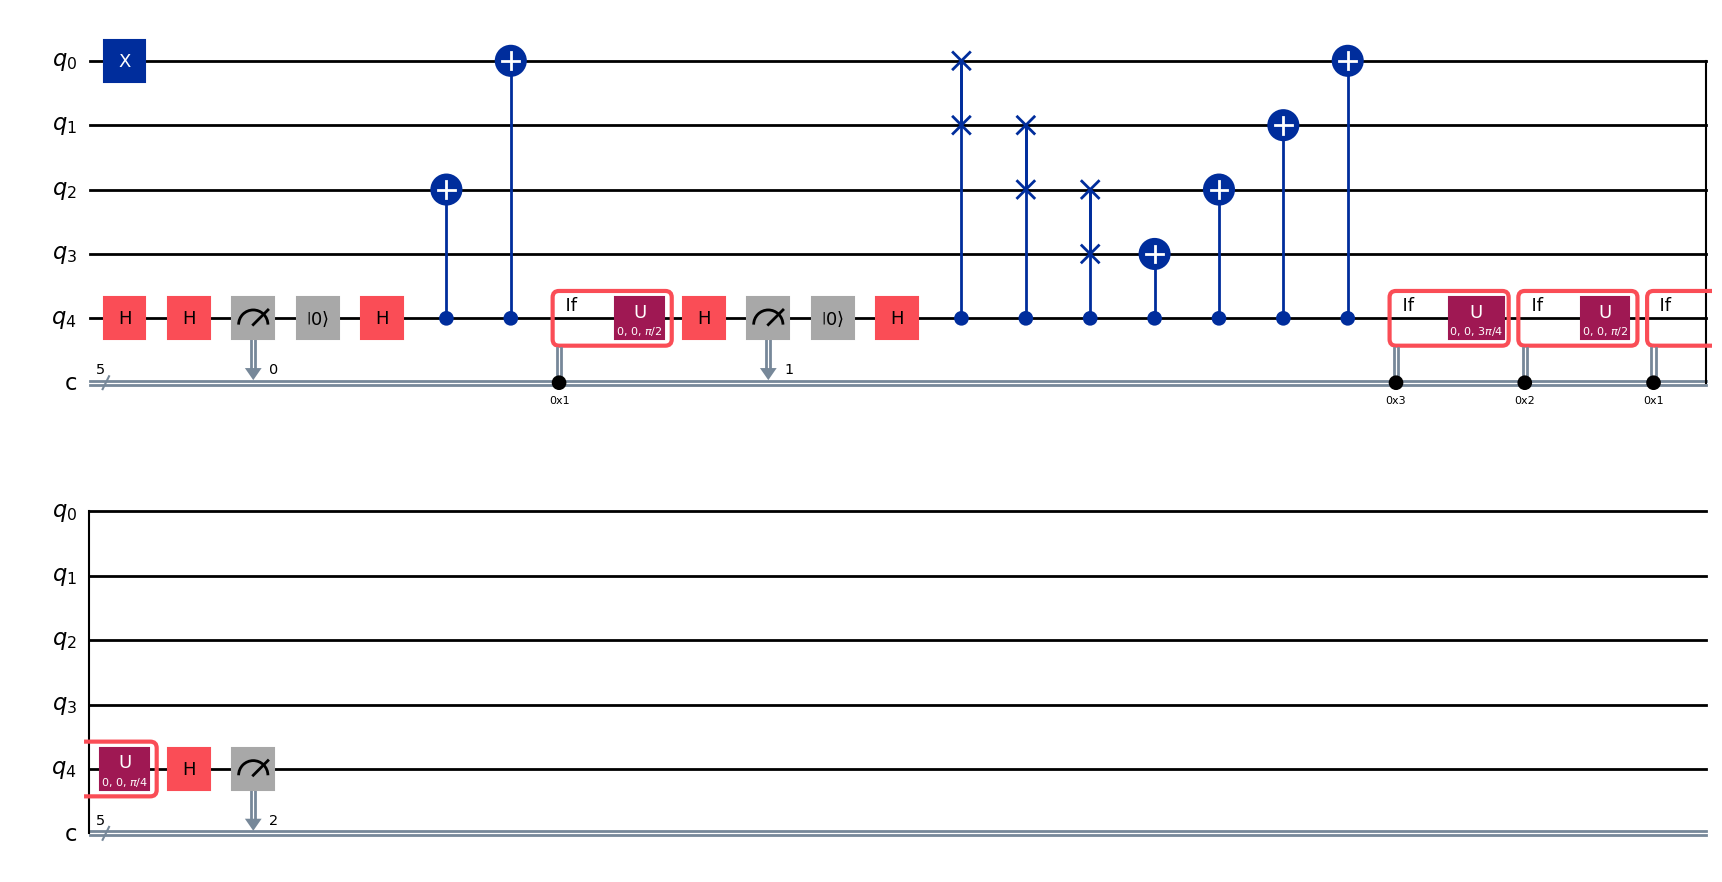

In [25]:
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,7)
shor.draw(output='mpl')

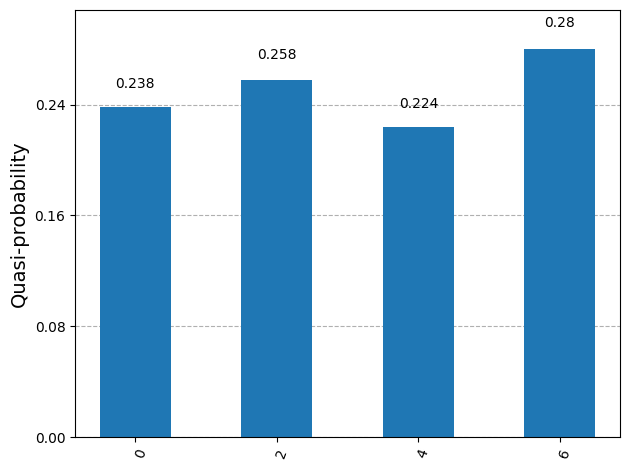

In [26]:
sampler = Sampler()

job = sampler.run(shor)
result = job.result()

dist0 = result.quasi_dists[0]

key_new = [str(key/2**2) for key in list(dist0.keys())]
dist1 = dict(zip(key_new, dist0.values()))

fig, ax = plt.subplots(1,1)
plot_histogram(dist0, ax=ax)
# plot_histogram(dist1, ax=ax[1])
plt.tight_layout()

Os valores 0, 2, 4 e 6 são os números com amplitude significativa e possuem probabilidades muito próximas. Usando expansão por frações para $x/2^3$, apenas 2 e 6 dão o período correto $r=4$.

# Calcular fatores usando o período calculado

Fazendo $p = gdc(a^{r/2}+1, 15) = gdc(7^{4/2}+1, 15)$ e $ q = gdc(a^{r/2}-1, 15) = gdc(7^{4/2}-1, 15)$, temos que $p=5$ e $q=3$, que são, de fato, os fatores de 15.